# Personal Information
Name:

StudentID: 

Email: 

Submitted on: **22.03.2024**

# Data Context

The data used here is a collection of 949 EPUB files provided through the supervisor of the thesis. The data has been gathered from https://www.standardebooks.org. The EPUB files are books that are in the public domain in the USA, meaning there is no copyright on the books anymore. This does however mean that it a sample of older books that have been published on paper, and later have been adapted to EPUB format by the Internet Archive. The main use of the data is to learn about which violations of the WCAG 2.1 standard occur in EPUB files, such that a repair tool can be created to fix the errors and make EPUB files compliant through software. The checking for errors is done with the ACE tool created by the DAISY Consortium.

However, as these books have only been adapted to EPUB form recently by the Internet Archive they might not be a good representative sample of EPUB files. Books that are published only in EPUB form or both on paper and in EPUB form in more recent years by independent authors or different publishing companies could create more variety in the data and the types of errors that can occur. Therefore this data set is a current place holder and hopefully gets expanded by previously mentioned types of EPUB files. The data analysis will be generalized to also be applicable to new data. When a better dataset is found this analysis will be applied to it as well, therefore this analysis is in some sense a placeholder.

In [1]:
# Imports
import os
import numpy as np
import json
import pandas as pd
import seaborn as sns
import zipfile
import re

### Data Loading

Create a dataframe of all the path files of the EPUB files

In [2]:
folder_path = 'D:/Documenten/Data Science/thesis/data/wetransfer_standardebooks-epub_2024-02-25_1759/standardebooks - epub'
files_in_folder = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
df = pd.DataFrame({'File_Paths': files_in_folder})

print(df.shape)
# df.head()

(949, 1)


As EPUB files are actually a zip file this code opens the zip files and extracts the date and the publisher for every EPUB and adds it to the path files dataframe

In [3]:
data = []

for zip_file_path in df.File_Paths:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        file_path = "epub/content.opf"    
        with zip_ref.open(file_path) as file:
            content = file.read()
            content_str = content.decode("utf-8")
            date_pattern = r'<dc:date>(.*?)</dc:date>'
            publisher_pattern = r'<dc:publisher id="publisher">(.*?)</dc:publisher>
            date_info = re.findall(date_pattern, content_str)
            publisher_info = re.findall(publisher_pattern, content_str)
            date_info = [date[:10] for date in date_info]
            for date, publisher in zip(date_info, publisher_info):
                data.append({"Date": date, "Publisher": publisher})

df_data = pd.DataFrame(data)
df = df.join(df_data)

pd.set_option('display.max_colwidth', None)
# df.head(3)


Check the range of dates in which the EPUB files were created

In [4]:
df.Date.min(), df.Date.max()

('2014-05-25', '2024-02-24')

Check how many unique publisheres there are

In [5]:
df.Publisher.describe()

count                 949
unique                  1
top       Standard Ebooks
freq                  949
Name: Publisher, dtype: object

### Run ACE EPUB compliance checker

Using the os library to run the ACE EPUB checker by the DAISY Consortium on every EPUB in the command line

In [ ]:
for file_path in df['File_Paths']:
    command = f'ace --subdir --outdir "D:/Documenten/Data Science/thesis/ePubs/results" "{file_path}"'
    os.system(command)

### Gather ACE results

ACE outputs the results as a .json file in a directory for every EPUB file. This code runs through all the directories and stores the file paths for the results in a new dataframe

In [6]:
folder_path = "D:/Documenten/Data Science/thesis/ePubs/results"
files_in_folder = os.listdir(folder_path)
checked_df = pd.DataFrame({'File_Paths': files_in_folder})

# checked_df.head()

Run through all the .json files and gather the metadata and extract the instances where there are errors and the EPUB did not pass the ACE check. Gather all metadata in metadf and errors in errorsdf

In [7]:
metadata=dict()
data=[]

for epubid in list(checked_df.File_Paths):
    ff='D:/Documenten/Data Science/thesis/ePubs/results/'+epubid+'/report.json'
    try:
        with open(ff) as f:
            d = json.load(f)
            metadata[epubid]=d['earl:testSubject']['metadata']
            A=d['assertions']
            errors= [ a['earl:test'] | {'epubID': epubid} 
                for d in A if d['earl:result']['earl:outcome']=='fail'
                    for a in d['assertions'] if a['earl:result']['earl:outcome']=='fail'
                    ]
            data= data+errors
            
    except:
        pass
# make dataframes        
metadf=pd.DataFrame.from_dict(metadata, orient='index')
errordf=pd.DataFrame(data)

# Analysis of results

Show the shapes of metadf and errordf as well as the head for both

In [8]:
metadf.shape, errordf.shape

((684, 31), (1861, 6))

In [9]:
# errordf.head()

In [10]:
pd.set_option('display.max_colwidth', 50)
# metadf.head(3)

Show the books with errors and show which errors they have and how many occurences of the error.

In [11]:
ER=errordf.groupby('epubID')['dct:title'].value_counts()
# ER

In total the dataset contains 1841 serious violations of WCAG 2.1 and 20 minor according to ACE

In [12]:
errordf['earl:impact'].value_counts()

earl:impact
serious    1841
minor        20
Name: count, dtype: int64

The unique errors that occur in the data

In [13]:
E=errordf.groupby('earl:impact')['dct:title'].value_counts()
E

earl:impact  dct:title                  
minor        epub-type-has-matching-role      20
serious      valid-lang                     1840
             epub-toc-order                    1
Name: count, dtype: int64

Plot the number of books (y-axis) with an x number of errors (x-axis). Here it can be seen that there are two outliers in this data set. These EPUB files will not be removed as they contain the same error many times. An automatic repair program should be capable to fix such errors, which is why these outliers are important as well

count     48.000000
mean      38.770833
std      119.511459
min        1.000000
25%        3.000000
50%        8.000000
75%       16.500000
max      767.000000
Name: earl:impact, dtype: float64

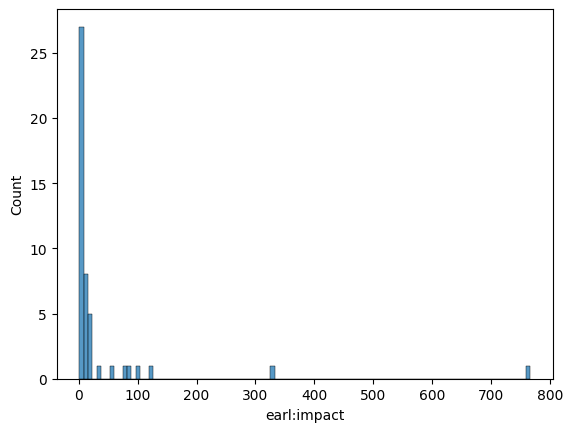

In [14]:
aantalfoutenperbook=errordf.groupby('epubID')['earl:impact'].count()
sns.histplot(aantalfoutenperbook)
aantalfoutenperbook.describe()

In [15]:
print(aantalfoutenperbook.skew())
print(aantalfoutenperbook.kurtosis())

5.338457457853851
30.991940813817667


Show the amount of errors and impact of errors per publisher. As this dataset contains only one publisher as mentioned before this is currently not useful information, but can be applied to new data 

In [16]:
medf=pd.merge(errordf,metadf, left_on='epubID', right_index=True)

In [17]:
medf2=medf.dropna(subset=['dc:publisher'])
medf2['dc:publisher'] = medf2['dc:publisher'].astype(str)

In [18]:
ErrorsPerPublisher=medf2.groupby('dc:publisher')['earl:impact'].value_counts().unstack().fillna(0).astype(int)
ErrorsPerPublisher

earl:impact,minor,serious
dc:publisher,,
Standard Ebooks,20,1841


In [19]:
ErrorsPerPublisher.sum(axis=1).describe()

count       1.0
mean     1861.0
std         NaN
min      1861.0
25%      1861.0
50%      1861.0
75%      1861.0
max      1861.0
dtype: float64